In [62]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Hypothesis testing
from scipy.stats import shapiro
import scipy.stats as stats


#settings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import time

In [63]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [65]:
def missing_info(data):
  '''
  Missing info function to check the missing values by count, % and unique values.
  '''
  details = pd.DataFrame()
  details['missing_values'] = round(data.isnull().sum())
  details['missing_values_%'] = round((data.isnull().sum()/len(data))*100,2)
  details['N_unique'] = data.nunique()
  details['dtype'] = data.dtypes
  details['mode'] = [data[col].value_counts().index[0] for col in data]
  return details

In [66]:
missing_info(df)

,missing_values,missing_values_%,N_unique,dtype,mode
userid,0,0.0,90189,int64,5793317
version,0,0.0,2,object,gate_40
sum_gamerounds,0,0.0,942,int64,1
retention_1,0,0.0,2,bool,False
retention_7,0,0.0,2,bool,False


###we can see there are no duplicate users in the userid

#EDA

In [67]:
#Summary stats per version
df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','std','max'])


,count,mean,median,std,max
version,,,,,
gate_30,44700,52.456264,17,256.716423,49854
gate_40,45489,51.298776,16,103.294416,2640


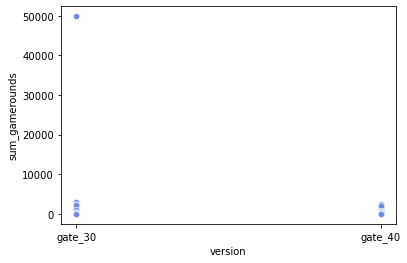

In [68]:
sns.scatterplot(data=df,x='version',y='sum_gamerounds')

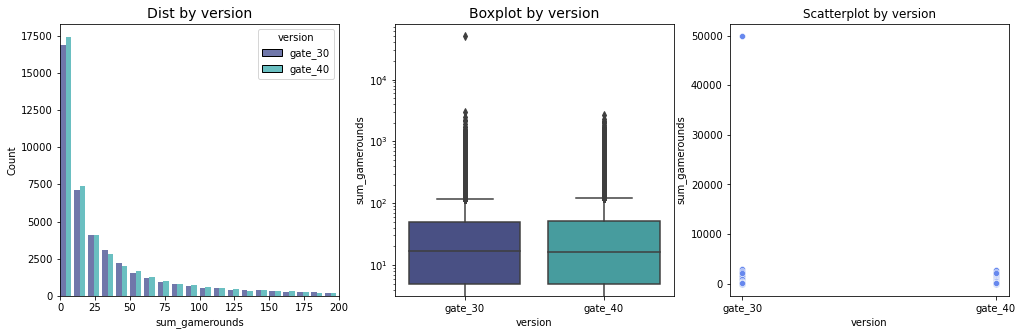

In [69]:
def plot_dist(df):
    fig,axes = plt.subplots(nrows=1,ncols=3, figsize=(17,5))
    sns.histplot(df,x='sum_gamerounds',label='hist',multiple='dodge',hue='version',ax=axes[0],shrink=.8, binwidth=10,palette='mako')
    sns.boxplot(data=df,x='version',y='sum_gamerounds',ax=axes[1],palette='mako')
    sns.scatterplot(data=df,x='version',y='sum_gamerounds',ax=axes[2],palette='mako')
    axes[0].set_xlim(0, 200)
    axes[1].set_yscale('log')
    axes[0].set_title('Dist by version', fontsize=14)
    axes[1].set_title('Boxplot by version', fontsize=14)
    axes[2].set_title('Scatterplot by version');

plot_dist(df)

In [70]:
df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
1%,0.000000
5%,1.000000
10%,1.000000
20%,3.000000
50%,16.000000
80%,67.000000


### we can see there is 1 outliner which needs to be dropped

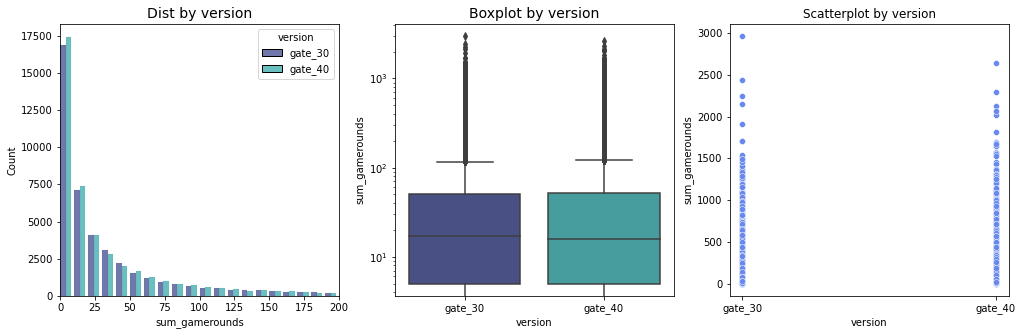

In [71]:
#remove outliers
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]

plot_dist(df)

In [72]:
df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','std','max'])

,count,mean,median,std,max
version,,,,,
gate_30,44699,51.342111,17,102.057598,2961
gate_40,45489,51.298776,16,103.294416,2640


# A/B Testing
- split the df (test & control).
- Shapiro-Wilk test.
    * if reject - Mann-Whitney U test
    * if accept - Levene Test for Homogeneity of variances  
         * if accept -> use T-Test
         * if reject -> use Welch Test
         

In [73]:
group_A = df[df['version']=='gate_30']
group_B = df[df['version']=='gate_40']
colors = ["tab:blue","tab:orange"]

In [74]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [75]:
#I'm going to use 3 metrics for the A/B testing.
variables = ['sum_gamerounds','retention_1','retention_7']

In [76]:
def AB_test(group_A,group_B,var):
    ### 1st step: shapiro_wilk test:
    test_stat_A, shapiro_pval_A = shapiro(group_A[var])
    test_stat_B, shapiro_pval_B = shapiro(group_B[var])
    print(f"Shapiro_Wilk_Test:\n\tGroupֹA pval={shapiro_pval_A} ,GroupֹB pval={shapiro_pval_B}\n\n\n")
    
    ##2nd step - incase normal distribution
    if (shapiro_pval_A>0.05 and shapiro_pval_B>0.05):
        print("We accept H0, hence the distribution of the 2 groups is normal/n")
        
 
        # Levene Test for Homogeneity of variances
        # H0: Homogeneity
        # H1: HomogeneitY
        levene_test = stats.levene(group_A[var], group_B[var])[1]
        

        if levene_test[1]  > 0.5:

            print("We accept the null hypothesis, hence the distribution of the 2 groups is homogeous/n ")
            ttest = stats.ttest_ind(group_A[var], group_B[var], equal_var=True)
            # H0: VARA == VARB 
            # H1: VARA != VARB
        else:
            # Heterogeneous
            print("We reject the null hypothesis, hence the distribution of the 2 groups is not homogeous/n ")
            ttest = stats.ttest_ind(group_A[var], group_B[var], equal_var=False)
            # H0: VARA == VARB
            # H1: VARA != VARB 
    
    #2nd step - in case not normal distribution Mann-Whitney U test
    else:
        # we Will use the Non Parametric Test
        ttest = stats.mannwhitneyu(group_A[var], group_B[var])
        # H0: VARA == VARB
        # H1: VARA != VARB

    
    
    #summary
    pvalue = round(ttest[1],3)
    if pvalue <= 0.5:
        print(f"testing the {var}: pval is {pvalue}, hence there we can reject the null hypothesis."
              "\ni.e there is a statistical significance between version_A & version_B")

    else:
        print(f"testing {var}: pval is {pvalue}, hence there is we accept the null hypothesis."
              "\ni.e there is no statistical significance between version_A & version_B")
    time.sleep(20)

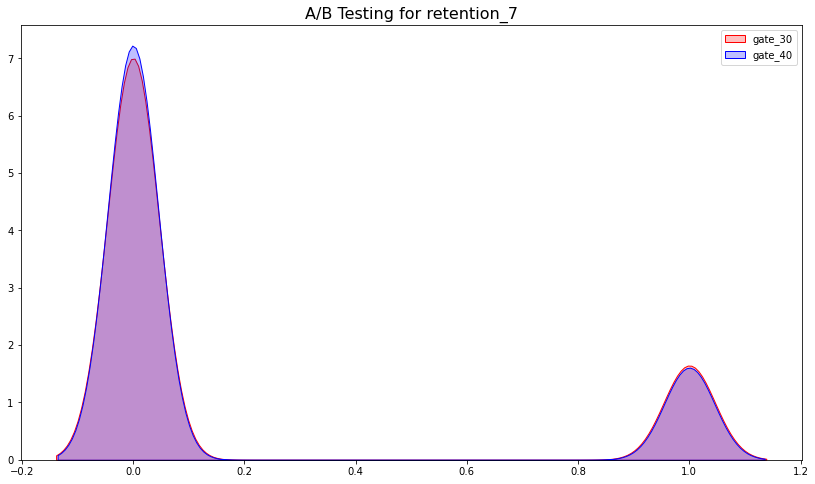

Shapiro_Wilk_Test:
	GroupֹA pval=0.0 ,GroupֹB pval=0.0



testing the retention_7: pval is 0.001, hence there we can reject the null hypothesis.
i.e there is a statistical significance between version_A & version_B


In [77]:
for var in variables:
    clear_output()
    fig,axes = plt.subplots(1,1,figsize=(14,8))
    axes.set_title(f"A/B Testing for {var}",fontsize=16)
    sns.kdeplot(group_A[var] , color="red", label="gate_30",ax=axes,fill=True)
    sns.kdeplot(group_B[var] , color="blue", label="gate_40",ax=axes,fill=True)
    axes.legend(loc=0,fontsize='medium')
    axes.set_ylabel('')
    axes.set_xlabel('')

    plt.show();
    AB_test(group_A,group_B,var)

In [78]:
df[['sum_gamerounds','retention_1','retention_7','version']].groupby('version').mean()

,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,51.342111,0.448198,0.190183
gate_40,51.298776,0.442283,0.182000


#### We can see there is a statistical significance for each of the vars. we can also see in final table above that gate_30 is performing better in all 3 parameters.

therefore my reccomendation based on the statistical results would be to continue with gate_30.